*Теоретический материал:* https://youtu.be/TGO-YPrfs1A

# Настройка окружения Colab

*Разбор данного раздела:* https://youtu.be/4zlh84tykx8?t=360

Движок box2d, на котором будет происходить симуляция посадки корабля рассчитан на работу, в первую очередь, в консоли, поэтому необходимо предварительно настроить среду 

In [1]:
# Будем обращаться к линукс-ядру напрямую с помощью команд на "!"
# Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)
# Код, представленный в документации разработчика
!apt install swig cmake libopenmpi-dev zlib1g-dev # cmake - сборка - аналог GNU Make, но с другим синтаксисом, libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!pip install stable-baselines==2.5.1 box2d box2d-kengz # устанавливаем непосредственно сам stable baseline и движок box2d

# если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # установка пакета для рендера видео
!pip install xvfbwrapper # установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба  
!apt-get update # обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!sudo apt-get install xvfb # установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!apt-get install xdpyinfo # пакет для вывода процессов, происходящих на сервере

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,

# Импорт библиотек



In [2]:
import gym # здесь лежат все модели для 
from gym import logger as gymlogger # загрузим библиотеку для изменения параметра вывода ошибок
from gym.wrappers import Monitor # библиотека для обертки видео из хранилища в ячейку
gymlogger.set_level(40) # для правильного отображения ошибок
import numpy as np # библиотека массивов numpy
import random # библиотека для генерации случайных значений
import matplotlib # библиотека для визуализации процессов
import matplotlib.pyplot as plt # библиотека для построения графика
%matplotlib inline
import glob # расширение для использования Unix обозначений при задании пути к файлу
import io # библиотека для работы с потоковыми данными
import base64 # расширение для преобразования в формат base64 (универсальный формат хранения сырых изображений в виде набора электрических сигналов)
from IPython.display import HTML # библиотека для кодирования в код HTML
import time # библиотека для расчета времени обучения

from IPython import display as ipythondisplay # для работы с "сырым" форматом (набор сигналов, а не пиксели)
from pyvirtualdisplay import Display # для создания окна дисплея


In [3]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

## LunarLander-v2

*Разбор данного раздела:* https://youtu.be/4zlh84tykx8?t=400


Задача данной симуляции заключается в посадке корабля на посадочную площадку. 

Оценивается то, *куда* вы его посадите и *как*. 

Для управления кораблем мы используем три двигателя: центральный, с левой ориентацией и правой ориентацией.

В итоге, на каждое из наших действий - **action** - среда выдает наблюдение - observation.

**Observation** - вектор размерности (8,), где первые шесть цифр - отклик самого физического движка (x-координата, y-координата, x-скорость, y-скорость, угол ракеты, укгловая скорость, факт приземления на левую ногу, факт приземления на правую ногу), а последние две цифры - координаты приземления. Т.е. пока ракета не приземлилась, последние два числа будут (0,0). Если на посадочной площадке, то (1,1). Если с какой-то из сторон, то (1,0) или (0,1) соответственно.

Как было сказано ранее, важно то, *как* мы приземляемся. 
За это отвечает награда - **reward**. Баллы могут складываться и вычитаться в зависимости от действия. Награда за переход от верхней части экрана к посадочной площадке и нулевой скорости составляет около 100..140 баллов. Если включен основной двигатель, то за каждый кадр (одно действие) -0,3 балла. Если ракета отходит от посадочной площадки, то присвоенная ранее награда за вычитается. При этом топливо бесконечно и эпизод заканчивается в момент приземления (либо ракета падает либо мягко приземляется). Допускается посадка вне посадочной площадки. За каждый контакт ноги с поверхностью +10 баллов. За падение (резкое приземление) -100 баллов, за мягкое приземление +100 баллов. 
В сумме решеная задача (за переход от верхней части экрана к посадочной площадке+мягкое приземление) дает 200..250 баллов. 

**Резюме**: на вход среды подаем одно из действий:

* 0 - ничего не делать 
* 1 - запустить двигатель с левой ориентацией
* 2 - запустить двигатель по центру
* 3 - запустить двигатель с правой ориентацией

на выходе получаем вектор observation и reward за текущее действие.
Эпизод будет идти до момента приземления.

**Цель**: максимизировать награду


![Lunar Lander](https://cdn-images-1.medium.com/max/960/1*f4VZPKOI0PYNWiwt0la0Rg.gif)




## Функции

In [4]:
'''

Функция, позволяющая записывать видео того,
что происходит в окружении и отображать это в колабе

'''

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
# Запускаем библиотеку 'gym' и среду 'LunarLander-v2', в 'env' - классы этой среды
env = gym.make('LunarLander-v2')

In [6]:
numBots = 100  # Количество ботов
popul = []  # Здесь будет лежать популяция

# Создаём бота размером 8х4, т.е. умножаем 'observation' (данные датчиков) на бот получаем 'reward' (награда)
for i in range(numBots):  
  bot = np.random.random((8,4))
  popul.append(bot)

## Посмотрим, как рандомно сгенерированный бот управляет нашей ракетой

In [7]:
env = wrap_env(env)  # Оборачиваем наше окружения для записи видео
env.seed(0)  # Симуляция одного и того же окружения (локации), сгенерированного рандомно
observation = env.reset()  # Обнуляем вектор наблюдения
i=0
action = 0

while True:
  env.render() # Рендер окружения
  # В качестве действия будем подавать значения нашего лучшего бота
  # Достаём из среды состояние нашего корабля, подаём в среду наше действие action
  observation,reward,done,_ = env.step(action) # Остлеживаем все параметры для подсчета функции значения, done - признак посадки (закончено действие)
  result = np.dot(observation,popul[np.random.randint(0, numBots-1)])  # Умножили observation на наш рандомный бот и получили result
  action = np.argmax(result)  # Выбираем максимальное значение действия и подаём его в среду (т.к. только одно действие в текущий момент времени)
  if done: 
    break;
            
env.close()
show_video()

# Генетические алгоритмы

*Разбор данного раздела:* https://youtu.be/4zlh84tykx8?t=1069


In [8]:
'''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
'''
def getSurvPopul(popul, val, nsurv, reverse):
  newpopul = [] # Двумерный массив для новой популяции
  sval= sorted(val, reverse=reverse) # Сортируем зачения в val в зависимости от параметра reverse
  for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
      index = val.index(sval[i]) # Получаем индекс i-того элемента sval в исходном массиве val
      newpopul.append(popul[index]) # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом
  return newpopul, sval # Возвращаем новую популяцию (из nsurv элементов) и сортированный список


'''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
'''
def getParents(curr_popul, nsurv):   
  indexp1 = random.randint(0, nsurv - 1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
  indexp2 = random.randint(0, nsurv - 1) # Случайный индекс второго родителя в диапазоне от 0 до nsurv - 1    
  botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
  botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2 
  return botp1,botp2 # Возвращаем обоих полученных ботов


'''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - j - номер компонента бота
'''
def crossPointFrom2Parents(botp1, botp2, j):
  pindex = np.random.random() # Получаем случайное число в диапазоне от 0 до 1
  
    #Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
  if pindex < 0.5:
      x = botp1[j]
  else:
      x = botp2[j]
  return x # Возвращаем значние бота
  

'''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
'''
def countValue(popul):
  action=0  # генерируем первое  действие случайным из пространства действий
                                     # 0 - ничего не делать 
                                     # 1 - запустить двигатель с левой ориентацией
                                     # 2 - запустить двигатель по центру
                                     # 3 - запустить двигатель с правой ориентацией

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  for bot in popul: # проходимся по каждому боту в популяции
    env.seed(0)  # При инициализации среда генерируется случайным образом каждый раз новая,
                 # поэтому ограничим интервал генерации - т.е. будем использовать только одну конкретную среду
    env.reset() # И обновлять окружение
    i=0 
    tmp=0
    done=False
    while done!=True:
      observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
      result = np.dot(observation,bot) # матрично перемножаем бота и вектор наблюдения для предсказания следующего движения
      action = np.argmax(result) # максимальный аргумент - наше движение
      # 'reward' - награда. За каждое действие считаем количество очков и складываем.
      # Потом отберём популяцию выживших с лучшими 'reward' (max ~ 300, см. вышк)
      tmp+=reward
    reward_list.append(tmp) # Функция, по которой будет вычисляться "успех текущей симуляции"
    
  return reward_list  

## Эволюция ботов на одной среде


0 2.665726900100708   [-13.79869371981323, -63.61217602491823, -84.3733503886058]
1 0.33750128746032715   [4.223415077860778, -8.522111645101774, -30.396588419484956]
2 0.2990145683288574   [10.351738987875635, 6.082601511080497, 4.090620663068648]
3 1.7520880699157715   [10.351738987875635, 10.246554282615588, -1.8811358913286682]
4 1.2290043830871582   [170.52147034509588, 143.3112333207012, 24.487778448246956]
5 1.4642581939697266   [40.88449190298525, 7.801963888752994, 6.082601511080497]
6 1.3583290576934814   [179.63463535440349, 167.69777970401083, 17.263614417855734]
7 0.8848514556884766   [185.2377632636621, 184.28469045875454, 34.28724814372762]
8 2.2087481021881104   [184.84432553587015, 183.49126861849552, 178.6227329748491]
9 1.049180030822754   [224.97595878832044, 198.03237454355167, 185.3330034339193]
10 1.5406782627105713   [230.02177860462177, 224.97595878832044, 216.92234056266432]
11 3.9767582416534424   [195.98626579885916, 184.3428838773447, 183.18776397398548]
12

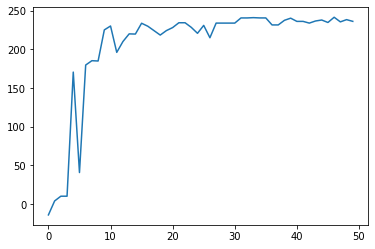

In [9]:
total=[] # Для построения графика
n = 40 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 50 # количество эпох
mut = 0.2 # коэфициент мутаций
curr_time = time.time()

for it in range(epohs): # создали список списков всех значений по эпохам
  val = countValue(popul) # считаем успех каждого из ботов
  newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
  print(it, time.time() - curr_time, " ", sval[0:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
  total.append(sval[0]) # заносим самого лучшего бота в список для построения графика эволюции
  curr_time = time.time() # Обновляем текущее время

  # проходимся по новой популяции
  for k in range(nnew):

    # вытаскиваем новых родителей
    botp1, botp2 = getParents(newpopul, nsurv) 
    newbot = [] # здесь будет новый бот

    for j in range(len(botp1)): # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
      x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
      for t in range(4):
        if random.random()<mut:
          x[t] += random.random()*1e-1
      newbot.append(x) # закидываем элемент в бота
    newpopul.append(newbot) # добавляем бота
  popul = newpopul # вывести список на эпоху
  popul = np.array(popul) # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
plt.plot(total)
print(np.mean(total)) 

# Каждый раз для страта корабля у нас подаются разные (рандомные) значения для корабля, поэтому
# Показав хорошие значения на одних условиях получаем плохие на других - идут скачки графика

In [10]:
val = countValue(popul) # считаем успех каждого из ботов
newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1

In [11]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,newpopul[1])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [12]:
# Посмотрим полученные очки на последнем шаге.
reward

100

## Тот же алгоритм на случайном окружении

In [13]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
# env.seed(0) 
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [14]:
reward

-100

## Эволюция ботов на случайно сгенерированных средах


In [15]:
def countValue(popul):
  action=0  # генерируем первое  действие случайным из пространства действий
                                     # 0 - ничего не делать 
                                     # 1 - запустить двигатель с левой ориентацией
                                     # 2 - запустить двигатель по центру
                                     # 3 - запустить двигатель с правой ориентацией

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  for bot in popul: # проходимся по каждому боту в популяции
   # env.seed(0)  # При инициализации среда генерируется случайным образом каждый раз новая,
                 # поэтому ограничим интервал генерации - т.е. будем использовать только одну конкретную среду
    env.reset() # И обновлять окружение
    i=0 
    tmp=0
    done=False
    while done!=True:
      observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
      result = np.dot(observation,bot) # матрично перемножаем бота и вектор наблюдения для предсказания следующего движения
      action = np.argmax(result) # максимальный аргумент - наше движение
      tmp+=reward
    reward_list.append(tmp) # Функция, по которой будет вычисляться "успех текущей симуляции"
    
  return reward_list  

0 0.8076353073120117   [230.66519399640794, 158.56768879949183, 19.688879806981475]
1 2.1269848346710205   [242.30165359857136, 227.5904074664134, 221.09866605533847]
2 2.9599361419677734   [252.5257477161541, 247.77279937950502, 246.62711085587136]
3 3.606652021408081   [264.408258999674, 256.92183525182776, 247.3794082825653]
4 1.9781875610351562   [266.3111740648824, 249.89376809938338, 234.2674516951995]
5 5.735628128051758   [252.21464080581615, 249.62415764003035, 209.22838410435526]
6 2.154160976409912   [220.25638930860663, 219.25443603861785, 176.74828556614588]
7 1.4934077262878418   [251.01890982984622, 238.55651055857015, 231.65427819854455]
8 4.09755539894104   [282.76765811151796, 215.2368695799347, 130.0716265746209]
9 3.787480115890503   [256.1552800249658, 255.45097923293164, 247.53342199259308]
10 7.1390111446380615   [226.22389102281647, 208.28898458017915, 191.56748580152168]
11 2.5852904319763184   [282.6711655873706, 252.13878833937298, 223.02246975342223]
12 2.43

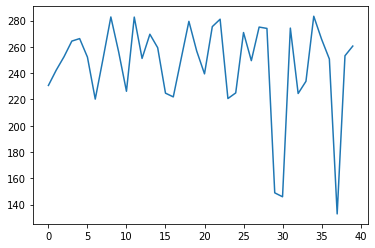

In [16]:
total=[] # Для построения графика
n = 100 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 40 # количество эпох
mut = 0.3 # коэфициент мутаций
curr_time = time.time()

for it in range(epohs): # создали список списков всех значений по эпохам
  val = countValue(popul) # считаем успех каждого из ботов
  newpopul, sval = getSurvPopul(popul, val, nsurv,1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
  print(it, time.time() - curr_time, " ", sval[0:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
  total.append(sval[0]) # заносим самого лучшего бота в список для построения графика эволюции
  curr_time = time.time() # Обновляем текущее время

 # проходимся по новой популяции
  for k in range(nnew):

    # вытаскиваем новых родителей
    botp1, botp2 = getParents(newpopul, nsurv) 
    newbot = [] # здесь будет новый бот

    for j in range(len(botp1)): # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
      x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
      for t in range(4):
        if random.random()<mut:
          x[t] += random.random()*1e-1
      newbot.append(x) # закидываем элемент в бота
    newpopul.append(newbot) # добавляем бота
  popul = newpopul # вывести список на эпоху
  popul = np.array(popul) # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
plt.plot(total)
print(np.mean(total)) 

In [17]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [18]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

In [19]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 0
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()